In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.impute import MissingIndicator
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model  import LogisticRegression

In [9]:
train = pd.read_csv("data/train.csv", index_col=0)
test = pd.read_csv("data/test.csv", index_col=0)  # does not contain targets

#Gender
train_no_gender = train.copy().drop(columns="Gender")
test_no_gedner = test.copy().drop(columns="Gender")

# Married
train_no_nan_married = train_no_gender.copy().dropna(axis=0, subset=["Married"])
train_no_nan_married = pd.get_dummies(train_no_nan_married, columns=["Married"], drop_first=True)

# Dependents
train_dependent_only_int = train_no_nan_married.copy().replace("3+", 3)
for number in range(0, 3):
    train_dependent_only_int = train_dependent_only_int.replace(f"{number}", number)

train_dependents_no_nan = train_dependent_only_int.copy()
median = np.nanmedian(train_dependent_only_int.Dependents)
train_dependents_no_nan["Missing_Dependents"] = [int(x) for x in train_dependent_only_int.Dependents.isnull().values]
train_dependents_no_nan.Dependents = train_dependent_only_int.copy().Dependents.fillna(median)

# Education
train_education_dummies = pd.get_dummies(train_dependents_no_nan.copy(), columns=["Education"], drop_first=True)

missing_ind = MissingIndicator(error_on_new=True, features="missing-only")
train_self_employed_encoded = train_education_dummies.copy()

# Self_Employed
train_self_employed_encoded["Missing_Self_Employed"] = missing_ind.fit_transform(train_self_employed_encoded.Self_Employed.values.reshape(-1, 1))
train_self_employed_encoded["Missing_Self_Employed"] = train_self_employed_encoded["Missing_Self_Employed"].replace([True, False], [1, 0])
train_self_employed_encoded.Self_Employed = train_self_employed_encoded.Self_Employed.replace([np.nan, "No", "Yes"], [0, 0, 1]) 

# Loan_Amount_Term
si = SimpleImputer(strategy="median")

train_imputed_loan_amount_term = train_self_employed_encoded.copy()
train_imputed_loan_amount_term.Loan_Amount_Term = si.fit_transform(train_imputed_loan_amount_term.Loan_Amount_Term.values.reshape(-1, 1))

# Credit_History
train_credit_history_no_nan = train_imputed_loan_amount_term.copy()

missing_ind = MissingIndicator(error_on_new=True, features="missing-only")
si = SimpleImputer(strategy="median")

train_credit_history_no_nan["Missing_Credit_History"] = missing_ind.fit_transform(train_credit_history_no_nan.Credit_History.values.reshape(-1, 1))
train_credit_history_no_nan["Missing_Credit_History"] = train_credit_history_no_nan["Missing_Credit_History"].replace([True, False], [1, 0])

train_credit_history_no_nan.Credit_History = si.fit_transform(train_credit_history_no_nan.Credit_History.values.reshape(-1, 1))

# Property_Area and Loan_Status
train_property_area_n_target = pd.get_dummies(train_credit_history_no_nan.copy(), columns=["Property_Area", "Loan_Status"], drop_first=True)

# Loan amount
train_LoanAmount_itterative_imputer = train_property_area_n_target.copy()

X = train_LoanAmount_itterative_imputer.iloc[:, :-1]
y = train_LoanAmount_itterative_imputer.iloc[:, -1]

imp_mean = IterativeImputer(random_state=0)
X = imp_mean.fit_transform(X)

X = pd.DataFrame(X, columns=train_LoanAmount_itterative_imputer.iloc[:, :-1].columns)

In [3]:
X

,Dependents,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Married_Yes,Missing_Dependents,Education_Not Graduate,Missing_Self_Employed,Missing_Credit_History,Property_Area_Semiurban,Property_Area_Urban
0,0.0,0.0,5849.0,0.0,138.028436,360.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,4583.0,1508.0,128.000000,360.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,3000.0,0.0,66.000000,360.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,2583.0,2358.0,120.000000,360.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,6000.0,0.0,141.000000,360.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,2900.0,0.0,71.000000,360.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,3.0,0.0,4106.0,0.0,40.000000,180.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
608,1.0,0.0,8072.0,240.0,253.000000,360.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
609,2.0,0.0,7583.0,0.0,187.000000,360.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
y

Loan_ID
LP001002    1
LP001003    0
LP001005    1
LP001006    1
LP001008    1
           ..
LP002978    1
LP002979    1
LP002983    1
LP002984    1
LP002990    0
Name: Loan_Status_Y, Length: 611, dtype: uint8

# Data to test and train 


In [10]:
#Test train split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [28]:
# Define the pipeline (regression method):
# Define the pipeline (regression method):


pipe_lr = make_pipeline(
    XGBClassifier(booster="gbtree", learning_rate=0.05, max_depth=10, n_estimators=100, min_child_weight=4, nthread=8, subsample=0.5)
)

pipe_lr.fit(X_train, y_train)

y_train_pred = pipe_lr.predict(X_train)
y_test_pred = pipe_lr.predict(X_test)


# MSE an R^2 score 
print('Accuracy: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))

[13:44:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.822, test: 0.799


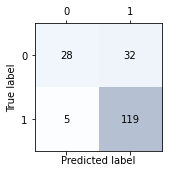

In [31]:
confmat = confusion_matrix(y_test, y_test_pred)


fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()
